In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
import pandas as pd
import numpy as np
%aimport AD_comparison_tools
%aimport AD_predictor_tools
%aimport ADpred_LambertTFs_helper
%aimport plot_AUPRC

import protfasta
import matplotlib.pyplot as plt
import seaborn as sns
#import metapredict as meta
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D

sns.set_theme(rc={'figure.figsize':(6,4), 'figure.dpi' : 300})
sns.set_style("white")
#from parrot import py_predictor

# Plan: Standardize predictor eval between AUPRC and TP/FP
- Use acidic activator TFs, assume we have all annotations for them

Steps:
1. Filter lambert TFs to those with acidic ADs --> `acidic_activator_TFs`
2. Tile `acidic_activator_TFs` at each predictor's input size with a step of 1
3. For each tile, if > 1 AA overlaps an acidic AD: tile is positive. Else, tile is negative.
4. AUPRC: Use scores to build AUPRC/ROC curves. Record empirical best threshold vs observed. 
5. F1 table: Use published threshold to binarize scores.


# 1. Filter lambert TFs to those with acidic ADs --> `acidic_activator_TFs`


In [12]:
known_ADs = pd.read_csv("../../SFARI/output/known_ADs_considering_isoforms_and_canonical_with_alerasool.csv")
known_ADs["charge"] = known_ADs["ProteinRegionSeq"].str.count("R") + \
                      known_ADs["ProteinRegionSeq"].str.count("K") - \
                      known_ADs["ProteinRegionSeq"].str.count("D") - \
                      known_ADs["ProteinRegionSeq"].str.count("E")
acidic_known_ADs = known_ADs[known_ADs["charge"] < -3]
# acidic_known_ADs = acidic_known_ADs.rename(columns={"Start": "annot_Start", "End": "annot_End"})
acidic_known_ADs

,Unnamed: 0,Gene,Start,End,uniprotID,Matching Isoforms,Canonical Transcript ID,orig_uniprotID,Reference,TileType,ProteinRegionSeq,charge
3,3,AHR,532,848,P35869,"[['P35869'], ['P35869'], ['P35869']]",ENST00000242057 / nan / ENST00000242057,P35869 / P35869 / P35869,"DelRosso et al. (P35869, 532_641) // PMID: 879...",TF / TF / TF,QDSKNSDLYSIMKNLGIDFEDIRHMQNEKFFRNDFSGEVDFRDIDL...,-20
5,5,AKAP8L,1,384,Q9ULX6,"[['Q9ULX6'], ['Q9ULX6'], ['Q9ULX6']]",nan / nan / ENST00000397410,Q9ULX6 / Q9ULX6 / Q9ULX6,"PMID: 11402034, Soto (Q9ULX6, 1_384) // activa...",TF / TF / TF,MSYTGFVQGSETTLQSTYSDTSAQPTCDYGYGTWNSGTNRGYEGYG...,-13
7,7,ARGFX,142,315,A6NJG6,"[['A6NJG6'], ['A6NJG6']]",ENST00000334384 / ENST00000334384,A6NJG6 / A6NJG6,"DelRosso et al. (A6NJG6, 142_251) // DelRosso ...",TF / TF,AKQRNQILPSKKNVPTSPRTSPSPYAFSPVISDFYSSLPSQPLDPS...,-8
8,8,ARNTL,543,626,O00327,"[['O00327-8'], ['O00327']]",ENST00000389707 / nan,O00327 / O00327,"DelRosso et al. (O00327-8, 542_625) // PMID: 1...",TF / TF,GGTPDIPSSGLLSGQAQENPGYPYSDSSSILGENPHIGIDMIDNDQ...,-13
9,9,BMAL2 / ARNTL2,542,636,Q8WYA1,"[['Q8WYA1'], ['Q8WYA1']]",ENST00000266503 / nan,Q8WYA1 / Q8WYA1,"DelRosso et al. (Q8WYA1, 542_636) // Staller A...",TF / TF,TGLMKDTHTVNCRSMSNKELFPPSPSEMGELEATRQNQSTVAVHSH...,-13
...,...,...,...,...,...,...,...,...,...,...,...,...
755,756,SPDYE4,41,120,A6NLX3,[['A6NLX3']],NaN,NaN,Alerasool et al,TF,DPSPQPQSLGLKRKSEWSDESEEELEEELELERAPEPEDTWVVETL...,-7
756,757,ATXN7L3,1,120,Q14CW9,"[['Q14CW9', 'Q14CW9-2']]",NaN,NaN,Alerasool et al,TF,MKMEEMSLSGLDNSKLEAIAQEIYADLVEDSCLGFCFEVHRAVKCG...,-5
757,758,FAM22F,361,500,A1L443,[['A1L443']],NaN,NaN,Alerasool et al,TF,PRPQRPAETNAHLPPPRPQRPAETKVPEEIPPEVVQEYVDIMEELL...,-18
759,760,SERTAD2,201,260,Q14140,[['Q14140']],NaN,NaN,Alerasool et al,TF,SEAGTQKLDGPQESRADDSKLMDSLPGNFEITTSTGFLTDLTLDDI...,-11


In [13]:
lambert_TFs = pd.read_csv("../../SFARI/output/lambert_TFs_10-21-24_with_DBD_coords.csv", index_col = 0).drop(columns = "DBD_coords_merged")
lambert_TFs["uniprotID"] = lambert_TFs["id"].str.split("|").str[1]
lambert_TFs

,id,ProteinSeq,uniprotID
0,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRDMAEA...,A0A087WUV0
1,sp|A0AVK6|E2F8_HUMAN Transcription factor E2F8...,MENEKENLFCEPHKRGLMKTPLKESTTANIVLAEIQPDFGPLTTPT...,A0AVK6
2,sp|A0PJY2|FEZF1_HUMAN Fez family zinc finger p...,MDSSCHNATTKMLATAPARGNMMSTSKPLAFSIERIMARTPEPKAL...,A0PJY2
3,sp|A1A519|F170A_HUMAN Protein FAM170A OS=Homo ...,MKRRQKRKHLENEESQETAEKGGGMSKSQEDALQPGSTRVAKGWSQ...,A1A519
4,sp|A1YPR0|ZBT7C_HUMAN Zinc finger and BTB doma...,MANDIDELIGIPFPNHSSEVLCSLNEQRHDGLLCDVLLVVQEQEYR...,A1YPR0
...,...,...,...
1608,sp|Q9Y6Q9|NCOA3_HUMAN Nuclear receptor coactiv...,MSGLGENLDPLASDSRKRKLPCDTPGQGLTCSGEKRRREQESKYIE...,Q9Y6Q9
1609,sp|Q9Y6R6|Z780B_HUMAN Zinc finger protein 780B...,MVHGSVTFRDVAIDFSQEEWECLQPDQRTLYRDVMLENYSHLISLG...,Q9Y6R6
1610,sp|Q9Y6X0|SETBP_HUMAN SET-binding protein OS=H...,MESRETLSSSRQRGGESDFLPVSSAKPPAAPGCAGEPLLSTPGPGK...,Q9Y6X0
1611,sp|Q9Y6X8|ZHX2_HUMAN Zinc fingers and homeobox...,MASKRKSTTPCMVRTSQVVEQDVPEEVDRAKEKGIGTPQPDVAKDS...,Q9Y6X8


In [14]:
acidic_activator_TFs = lambert_TFs[lambert_TFs["uniprotID"].isin(acidic_known_ADs["uniprotID"])]
acidic_activator_TFs = acidic_activator_TFs.rename(columns = {"id" : "GeneName", "ProteinSeq" : "Sequence"})
acidic_activator_TFs

,GeneName,Sequence,uniprotID
17,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,MRNRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLSKLECSG...,A6NJG6
40,sp|A8MYZ6|FOXO6_HUMAN Forkhead box protein O6 ...,MAAKLRAHQVDVDPDFAPQSRPRSCTWPLPQPDLAGDEDGALGAGV...,A8MYZ6
41,sp|A8MZ59|LEUTX_HUMAN Paired-like homeodomain ...,MFEGPRRYRRPRTRFLSKQLTALRELLEKTMHPSLATMGKLASKLQ...,A8MZ59
53,sp|O00321|ETV2_HUMAN ETS translocation variant...,MDLWNWDEASPQEVPPGNKLAGLEGAKLGFCFPDLALQGDTPTATA...,O00321
54,sp|O00327|BMAL1_HUMAN Basic helix-loop-helix A...,MADQRMDISSTISDFMSPGPTDLLSSSLGTSGVDCNRKRKGSSTDY...,O00327
...,...,...,...
1598,sp|Q9Y5Q3|MAFB_HUMAN Transcription factor MafB...,MAAELSMGPELPTSPLAMEYVNDFDLLKFDVKKEPLGRAERPGRPC...,Q9Y5Q3
1600,sp|Q9Y5R6|DMRT1_HUMAN Doublesex- and mab-3-rel...,MPNDEAFSKPSTPSEAPHAPGVPPQGRAGGFGKASGALVGAASGSS...,Q9Y5R6
1602,sp|Q9Y5W3|KLF2_HUMAN Krueppel-like factor 2 OS...,MALSEPILPSFSTFASPCRERGLQERWPRAEPESGGTDDDLNSVLD...,Q9Y5W3
1606,sp|Q9Y692|GMEB1_HUMAN Glucocorticoid modulator...,MANAEVSVPVGDVVVVPTEGNEGENPEDTKTQVILQLQPVQQGLFI...,Q9Y692


So we are using 479 acidic AD annotations out of 761 AD annotations. These 479 acidic AD annotations are on 317 TFs out of 1613 total TFs.

# 2. Tile `acidic_activator_TFs` at each predictor's input size with a step of 1

In [15]:
acidic_activator_TFs_40_tiled = AD_predictor_tools.makeTilingDF_fromDF(acidic_activator_TFs, add_gene_id=False, 
                                                                       window_size=40, window_spacing=1)
acidic_activator_TFs_40_tiled = acidic_activator_TFs_40_tiled.rename(columns={"GeneName": "uniprotID", "StartPosition": "Start", "EndPosition": "End"})
acidic_activator_TFs_40_tiled

Creating new Tiling DF at  ../data/TilingDFs/temp248200450529480540694567900243711471761_size_40_space_1_AAs_W,F,Y,M,L,Q.csv
Window Size = 40  and Window spacing = 1
Number of Tiling Windows: 187252


,ProteinWindowSeq,uniprotID,Start,End,W,F,Y,M,L,Q,K,R,D,E,Charge
0,MRNRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLS,A6NJG6,0,40,0,2,1,3,2,2,1,3,2,1,1
1,RNRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLSK,A6NJG6,1,41,0,2,1,2,2,2,2,3,2,1,2
2,NRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLSKL,A6NJG6,2,42,0,2,1,2,3,2,2,2,2,1,1
3,RMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLSKLE,A6NJG6,3,43,0,2,1,2,3,2,2,2,2,2,0
4,MAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLSKLEC,A6NJG6,4,44,0,2,1,2,3,2,2,1,2,2,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187247,SLLTKKQDQAARKIMRFLRRCRHSPLVDHRLYKRSERIEK,Q9Y6Y1,1629,1669,0,1,1,1,5,2,5,8,2,2,9
187248,LLTKKQDQAARKIMRFLRRCRHSPLVDHRLYKRSERIEKG,Q9Y6Y1,1630,1670,0,1,1,1,5,2,5,8,2,2,9
187249,LTKKQDQAARKIMRFLRRCRHSPLVDHRLYKRSERIEKGQ,Q9Y6Y1,1631,1671,0,1,1,1,4,3,5,8,2,2,9
187250,TKKQDQAARKIMRFLRRCRHSPLVDHRLYKRSERIEKGQG,Q9Y6Y1,1632,1672,0,1,1,1,3,3,5,8,2,2,9


In [16]:
acidic_activator_TFs_53_tiled = AD_predictor_tools.makeTilingDF_fromDF(acidic_activator_TFs, add_gene_id=False, 
                                                                       window_size=53, window_spacing=1)
acidic_activator_TFs_53_tiled = acidic_activator_TFs_53_tiled.rename(columns={"GeneName": "uniprotID", "StartPosition": "Start", "EndPosition": "End"})
acidic_activator_TFs_53_tiled

Creating new Tiling DF at  ../data/TilingDFs/temp248287143979163878466817619186462506504_size_53_space_1_AAs_W,F,Y,M,L,Q.csv
Window Size = 53  and Window spacing = 1
Number of Tiling Windows: 183131


,ProteinWindowSeq,uniprotID,Start,End,W,F,Y,M,L,Q,K,R,D,E,Charge
0,MRNRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLSKLECSG...,A6NJG6,0,53,0,2,2,3,3,2,2,3,2,2,1
1,RNRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLSKLECSGT...,A6NJG6,1,54,0,2,2,2,4,2,2,3,2,2,1
2,NRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLSKLECSGTV...,A6NJG6,2,55,0,2,2,2,4,2,2,2,2,2,0
3,RMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLSKLECSGTVS...,A6NJG6,3,56,0,2,2,2,5,2,2,2,2,2,0
4,MAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLSKLECSGTVSA...,A6NJG6,4,57,0,2,2,2,5,2,2,1,2,2,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183126,RRTAVIVQQKLRSSLLTKKQDQAARKIMRFLRRCRHSPLVDHRLYK...,Q9Y6Y1,1616,1669,0,1,1,1,6,4,6,11,2,2,13
183127,RTAVIVQQKLRSSLLTKKQDQAARKIMRFLRRCRHSPLVDHRLYKR...,Q9Y6Y1,1617,1670,0,1,1,1,6,4,6,10,2,2,12
183128,TAVIVQQKLRSSLLTKKQDQAARKIMRFLRRCRHSPLVDHRLYKRS...,Q9Y6Y1,1618,1671,0,1,1,1,6,5,6,9,2,2,11
183129,AVIVQQKLRSSLLTKKQDQAARKIMRFLRRCRHSPLVDHRLYKRSE...,Q9Y6Y1,1619,1672,0,1,1,1,6,5,6,9,2,2,11


In [17]:
acidic_activator_TFs_30_tiled = AD_predictor_tools.makeTilingDF_fromDF(acidic_activator_TFs, add_gene_id=False, 
                                                                       window_size=30, window_spacing=1)
acidic_activator_TFs_30_tiled = acidic_activator_TFs_30_tiled.rename(columns={"GeneName": "uniprotID", "StartPosition": "Start", "EndPosition": "End"})

acidic_activator_TFs_30_tiled

Creating new Tiling DF at  ../data/TilingDFs/temp119879456830218211647657036599026723153_size_30_space_1_AAs_W,F,Y,M,L,Q.csv
Window Size = 30  and Window spacing = 1
Number of Tiling Windows: 190422


,ProteinWindowSeq,uniprotID,Start,End,W,F,Y,M,L,Q,K,R,D,E,Charge
0,MRNRMAPENPQPDPFINRNYSNMKVIPPQD,A6NJG6,0,30,0,1,1,3,0,2,1,3,2,1,1
1,RNRMAPENPQPDPFINRNYSNMKVIPPQDP,A6NJG6,1,31,0,1,1,2,0,2,1,3,2,1,1
2,NRMAPENPQPDPFINRNYSNMKVIPPQDPA,A6NJG6,2,32,0,1,1,2,0,2,1,2,2,1,0
3,RMAPENPQPDPFINRNYSNMKVIPPQDPAS,A6NJG6,3,33,0,1,1,2,0,2,1,2,2,1,0
4,MAPENPQPDPFINRNYSNMKVIPPQDPASP,A6NJG6,4,34,0,1,1,2,0,2,1,1,2,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190417,ARKIMRFLRRCRHSPLVDHRLYKRSERIEK,Q9Y6Y1,1639,1669,0,1,1,1,3,0,3,8,1,2,8
190418,RKIMRFLRRCRHSPLVDHRLYKRSERIEKG,Q9Y6Y1,1640,1670,0,1,1,1,3,0,3,8,1,2,8
190419,KIMRFLRRCRHSPLVDHRLYKRSERIEKGQ,Q9Y6Y1,1641,1671,0,1,1,1,3,1,3,7,1,2,7
190420,IMRFLRRCRHSPLVDHRLYKRSERIEKGQG,Q9Y6Y1,1642,1672,0,1,1,1,3,1,2,7,1,2,6


# 3. For each tile, if > 1 AA overlaps an acidic AD: tile is positive. Else, tile is negative.

In [18]:
AD_comparison_tools.add_col_contains_prediction(acidic_activator_TFs_40_tiled, acidic_known_ADs, result_col_name = "acidic_known_AD")
acidic_activator_TFs_40_tiled["acidic_known_AD"].value_counts()

acidic_known_AD
False    132269
True      54983
Name: count, dtype: int64

In [19]:
sum(acidic_activator_TFs_40_tiled["acidic_known_AD"]) / len(acidic_activator_TFs_40_tiled)

0.2936310426590904

In [20]:
AD_comparison_tools.add_col_contains_prediction(acidic_activator_TFs_53_tiled, acidic_known_ADs, result_col_name = "acidic_known_AD")
acidic_activator_TFs_53_tiled["acidic_known_AD"].value_counts()

acidic_known_AD
False    126861
True      56270
Name: count, dtype: int64

In [21]:
sum(acidic_activator_TFs_53_tiled["acidic_known_AD"]) / len(acidic_activator_TFs_53_tiled)

0.3072663830809639

In [22]:
AD_comparison_tools.add_col_contains_prediction(acidic_activator_TFs_30_tiled, acidic_known_ADs, result_col_name = "acidic_known_AD")
acidic_activator_TFs_30_tiled["acidic_known_AD"].value_counts()

acidic_known_AD
False    136539
True      53883
Name: count, dtype: int64

In [23]:
sum(acidic_activator_TFs_30_tiled["acidic_known_AD"]) / len(acidic_activator_TFs_30_tiled)

0.28296625389923435

In [24]:
acidic_activator_TFs_40_tiled = acidic_activator_TFs_40_tiled.rename(columns = {"ProteinWindowSeq" : "tile"})
acidic_activator_TFs_53_tiled = acidic_activator_TFs_53_tiled.rename(columns={"ProteinWindowSeq": "tile"})
acidic_activator_TFs_30_tiled = acidic_activator_TFs_30_tiled.rename(columns={"ProteinWindowSeq": "tile"})

# 4. AUPRC: Use scores to build AUPRC/ROC curves. Record empirical best threshold vs observed. 

In [25]:
adhunter_prepared = pd.read_csv("../../AD_predictor_project/Paper_AD_predictor/AD_predictor/output/TF_pred_output_MZ/adhunter.csv", index_col=0)
adhunter_prepared["uniprotID"] = adhunter_prepared["GeneName"].str.split("|").str[1]
# subsets to acidic activator TFs
adhunter_with_truth = pd.merge(adhunter_prepared, acidic_activator_TFs_40_tiled[["tile", "acidic_known_AD"]], on = 'tile').drop_duplicates()#.dropna()
adhunter_with_truth 

,tile,adhunter,GeneName,Start,End,uniprotID,acidic_known_AD
0,MLDMSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSE,21398.926,sp|P57073|SOX8_HUMAN,0,40,P57073,False
1,LDMSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSEG,19002.781,sp|P57073|SOX8_HUMAN,1,41,P57073,False
2,DMSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSEGL,21724.012,sp|P57073|SOX8_HUMAN,2,42,P57073,False
3,MSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSEGLG,21165.188,sp|P57073|SOX8_HUMAN,3,43,P57073,False
4,SEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSEGLGR,22060.988,sp|P57073|SOX8_HUMAN,4,44,P57073,False
...,...,...,...,...,...,...,...
189850,GPLHSMSAEVFGPSPPFSSLSVNGGASYGNHLSHPPEMNE,44033.600,sp|P48742|LHX1_HUMAN,362,402,P48742,False
189851,PLHSMSAEVFGPSPPFSSLSVNGGASYGNHLSHPPEMNEA,50841.470,sp|P48742|LHX1_HUMAN,363,403,P48742,False
189852,LHSMSAEVFGPSPPFSSLSVNGGASYGNHLSHPPEMNEAA,51227.438,sp|P48742|LHX1_HUMAN,364,404,P48742,False
189853,HSMSAEVFGPSPPFSSLSVNGGASYGNHLSHPPEMNEAAV,55368.594,sp|P48742|LHX1_HUMAN,365,405,P48742,False


In [26]:
adpred_prepared = pd.read_csv("../../AD_predictor_project/Paper_AD_predictor/AD_predictor/output/TF_pred_output_MZ/adpred.csv", index_col=0)
adpred_prepared["uniprotID"] = adpred_prepared["GeneName"].str.split("|").str[1]
adpred_with_truth = pd.merge(adpred_prepared, acidic_activator_TFs_30_tiled[["tile", "acidic_known_AD"]], on = 'tile').drop_duplicates()#.dropna()
adpred_with_truth

,tile,adpred,GeneName,Start,End,uniprotID,acidic_known_AD
0,MLDMSEARSQPPCSPSGTASSMSHVEDSDS,0.000990,sp|P57073|SOX8_HUMAN,0,30,P57073,False
1,LDMSEARSQPPCSPSGTASSMSHVEDSDSD,0.000966,sp|P57073|SOX8_HUMAN,1,31,P57073,False
2,DMSEARSQPPCSPSGTASSMSHVEDSDSDA,0.000446,sp|P57073|SOX8_HUMAN,2,32,P57073,False
3,MSEARSQPPCSPSGTASSMSHVEDSDSDAP,0.000357,sp|P57073|SOX8_HUMAN,3,33,P57073,False
4,SEARSQPPCSPSGTASSMSHVEDSDSDAPP,0.000340,sp|P57073|SOX8_HUMAN,4,34,P57073,False
...,...,...,...,...,...,...,...
171325,LNQSHLSQHLNKGTPMKTQKRAALYTWYVR,0.000611,sp|P35680|HNF1B_HUMAN,144,174,P35680,False
171326,NQSHLSQHLNKGTPMKTQKRAALYTWYVRK,0.000197,sp|P35680|HNF1B_HUMAN,145,175,P35680,False
171327,QSHLSQHLNKGTPMKTQKRAALYTWYVRKQ,0.000136,sp|P35680|HNF1B_HUMAN,146,176,P35680,False
171328,SHLSQHLNKGTPMKTQKRAALYTWYVRKQR,0.000055,sp|P35680|HNF1B_HUMAN,147,177,P35680,False


In [27]:
tada_prepared = pd.read_csv("../../AD_predictor_project/Paper_AD_predictor/AD_predictor/output/TF_pred_output_MZ/tada.csv", index_col=0)

#tada_prepared = tada_prepared.rename(columns = {"GeneName" : "uniprotID"})
tada_with_truth = pd.merge(tada_prepared, acidic_activator_TFs_40_tiled[["tile", "acidic_known_AD"]], on = 'tile').drop_duplicates()#.dropna()
tada_with_truth

,uniprotID,tile,Start,End,tada,acidic_known_AD
0,P57073,MLDMSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSE,0,40,0.188203,False
1,P57073,LDMSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSEG,1,41,0.175274,False
2,P57073,DMSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSEGL,2,42,0.171019,False
3,P57073,MSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSEGLG,3,43,0.173125,False
4,P57073,SEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSEGLGR,4,44,0.161011,False
...,...,...,...,...,...,...
189850,P48742,GPLHSMSAEVFGPSPPFSSLSVNGGASYGNHLSHPPEMNE,362,402,0.216110,False
189851,P48742,PLHSMSAEVFGPSPPFSSLSVNGGASYGNHLSHPPEMNEA,363,403,0.214454,False
189852,P48742,LHSMSAEVFGPSPPFSSLSVNGGASYGNHLSHPPEMNEAA,364,404,0.200905,False
189853,P48742,HSMSAEVFGPSPPFSSLSVNGGASYGNHLSHPPEMNEAAV,365,405,0.194064,False


In [28]:
paddle_prepared = pd.read_csv("../../AD_predictor_project/Paper_AD_predictor/AD_predictor/output/TF_pred_output_MZ/paddle.csv", index_col=0)
paddle_prepared["uniprotID"] = paddle_prepared["GeneName"].str.split("|").str[1]
paddle_with_truth = pd.merge(paddle_prepared, acidic_activator_TFs_53_tiled[["tile", "acidic_known_AD"]], on = 'tile').drop_duplicates()#.dropna()
paddle_with_truth

,tile,preds,GeneName,Start,End,uniprotID,acidic_known_AD
0,MAEDDPYLGRPEQMFHLDPSLTHTIFNPEVFQPQMALPTDGPYLQI...,1.674334,sp|P19838|NFKB1_HUMAN,0,53,P19838,False
1,AEDDPYLGRPEQMFHLDPSLTHTIFNPEVFQPQMALPTDGPYLQIL...,1.473201,sp|P19838|NFKB1_HUMAN,1,54,P19838,False
2,EDDPYLGRPEQMFHLDPSLTHTIFNPEVFQPQMALPTDGPYLQILE...,1.325688,sp|P19838|NFKB1_HUMAN,2,55,P19838,False
3,DDPYLGRPEQMFHLDPSLTHTIFNPEVFQPQMALPTDGPYLQILEQ...,1.210825,sp|P19838|NFKB1_HUMAN,3,56,P19838,False
4,DPYLGRPEQMFHLDPSLTHTIFNPEVFQPQMALPTDGPYLQILEQP...,1.109244,sp|P19838|NFKB1_HUMAN,4,57,P19838,False
...,...,...,...,...,...,...,...
174434,SEMGPASKPSEDTGLATPARYREHRSNSQQGKSPDLHLLVDVACKQ...,0.014366,sp|Q4G112|HSF5_HUMAN,539,592,Q4G112,False
174435,EMGPASKPSEDTGLATPARYREHRSNSQQGKSPDLHLLVDVACKQE...,0.008490,sp|Q4G112|HSF5_HUMAN,540,593,Q4G112,False
174436,MGPASKPSEDTGLATPARYREHRSNSQQGKSPDLHLLVDVACKQER...,-0.015364,sp|Q4G112|HSF5_HUMAN,541,594,Q4G112,False
174437,GPASKPSEDTGLATPARYREHRSNSQQGKSPDLHLLVDVACKQERF...,-0.022012,sp|Q4G112|HSF5_HUMAN,542,595,Q4G112,False


In [29]:
parrot_erij_prepared = pd.read_csv("../data/tf_30_AA_parrot_erij_pred.csv", index_col=0)
parrot_erij_prepared["erij_pred"]= parrot_erij_prepared["erij_pred"].str.replace("[", "")
parrot_erij_prepared["erij_pred"]= parrot_erij_prepared["erij_pred"].str.replace("]", "")
parrot_erij_prepared["erij_pred"] = parrot_erij_prepared["erij_pred"].str.split(r'\s+')
parrot_erij_prepared["erij_pred"] = parrot_erij_prepared["erij_pred"].apply(lambda x: float(x[1]))
parrot_erij_prepared["uniprotID"] = parrot_erij_prepared["GeneName"].str.split("|").str[1]
#parrot_erij_prepared = parrot_erij_prepared[["ProteinWindowSeq", "GeneName", "StartPosition", "EndPosition", "erij_pred"]]
parrot_erij_prepared = parrot_erij_prepared.rename(columns = {"ProteinWindowSeq" : "tile",
                                                              "StartPosition" : "Start",
                                                              "EndPosition" : "End"})

parrot_erij_with_truth = pd.merge(parrot_erij_prepared, acidic_activator_TFs_30_tiled[["tile", "acidic_known_AD"]], on = 'tile').drop_duplicates()#.dropna()
parrot_erij_with_truth

,tile,GeneName,Start,End,W,F,Y,M,L,Q,K,R,D,E,Charge,erij_pred,uniprotID,acidic_known_AD
0,MRNRMAPENPQPDPFINRNYSNMKVIPPQD,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,0,30,0,1,1,3,0,2,1,3,2,1,1,0.011447,A6NJG6,False
1,RNRMAPENPQPDPFINRNYSNMKVIPPQDP,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,1,31,0,1,1,2,0,2,1,3,2,1,1,0.009333,A6NJG6,False
2,NRMAPENPQPDPFINRNYSNMKVIPPQDPA,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,2,32,0,1,1,2,0,2,1,2,2,1,0,0.011541,A6NJG6,False
3,RMAPENPQPDPFINRNYSNMKVIPPQDPAS,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,3,33,0,1,1,2,0,2,1,2,2,1,0,0.011801,A6NJG6,False
4,MAPENPQPDPFINRNYSNMKVIPPQDPASP,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,4,34,0,1,1,2,0,2,1,1,2,1,-1,0.019178,A6NJG6,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196262,ARKIMRFLRRCRHSPLVDHRLYKRSERIEK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1639,1669,0,1,1,1,3,0,3,8,1,2,8,0.018220,Q9Y6Y1,False
196263,RKIMRFLRRCRHSPLVDHRLYKRSERIEKG,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1640,1670,0,1,1,1,3,0,3,8,1,2,8,0.014282,Q9Y6Y1,False
196264,KIMRFLRRCRHSPLVDHRLYKRSERIEKGQ,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1641,1671,0,1,1,1,3,1,3,7,1,2,7,0.015638,Q9Y6Y1,False
196265,IMRFLRRCRHSPLVDHRLYKRSERIEKGQG,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1642,1672,0,1,1,1,3,1,2,7,1,2,6,0.023222,Q9Y6Y1,False


In [30]:
parrot_paddle_prepared = pd.read_csv("../data/tf_53_AA_parrot_paddle_pred.csv", index_col=0)
parrot_paddle_prepared = parrot_paddle_prepared[["ProteinWindowSeq", "GeneName", "StartPosition", "EndPosition", "padd_pred"]]
parrot_paddle_prepared["padd_pred"]= parrot_paddle_prepared["padd_pred"].str.replace("[", "")
parrot_paddle_prepared["padd_pred"]= parrot_paddle_prepared["padd_pred"].str.replace("]", "")
parrot_paddle_prepared["padd_pred"] = parrot_paddle_prepared["padd_pred"].str.split(r'\s+')
parrot_paddle_prepared["padd_pred"] = parrot_paddle_prepared["padd_pred"].apply(lambda x: float(x[0]))
parrot_paddle_prepared["uniprotID"] = parrot_paddle_prepared["GeneName"].str.split("|").str[1]
parrot_paddle_prepared = parrot_paddle_prepared.rename(columns = {"ProteinWindowSeq" : "tile",
                                                              "StartPosition" : "Start",
                                                              "EndPosition" : "End"})
parrot_paddle_with_truth = pd.merge(parrot_paddle_prepared, acidic_activator_TFs_53_tiled[["tile", "acidic_known_AD"]], on = 'tile').drop_duplicates()#.dropna()
parrot_paddle_with_truth

,tile,GeneName,Start,End,padd_pred,uniprotID,acidic_known_AD
0,MRNRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLSKLECSG...,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,0,53,0.294699,A6NJG6,False
1,RNRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLSKLECSGT...,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,1,54,0.215838,A6NJG6,False
2,NRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLSKLECSGTV...,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,2,55,0.450520,A6NJG6,False
3,RMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLSKLECSGTVS...,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,3,56,0.251041,A6NJG6,False
4,MAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLSKLECSGTVSA...,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,4,57,0.478560,A6NJG6,False
...,...,...,...,...,...,...,...
185463,RRTAVIVQQKLRSSLLTKKQDQAARKIMRFLRRCRHSPLVDHRLYK...,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1616,1669,-0.021582,Q9Y6Y1,False
185464,RTAVIVQQKLRSSLLTKKQDQAARKIMRFLRRCRHSPLVDHRLYKR...,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1617,1670,-0.057513,Q9Y6Y1,False
185465,TAVIVQQKLRSSLLTKKQDQAARKIMRFLRRCRHSPLVDHRLYKRS...,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1618,1671,-0.083714,Q9Y6Y1,False
185466,AVIVQQKLRSSLLTKKQDQAARKIMRFLRRCRHSPLVDHRLYKRSE...,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1619,1672,-0.056512,Q9Y6Y1,False


# 4. Pt 2: Plot curves 

In [32]:
color_palette_dict = {"adpred" : (0.5294117647058824, 0.23137254901960785, 0.3803921568627451),
                      "PARROT_erijman" : (0.5607843137254902, 0.2823529411764706, 0.615686274509804),
                      "adhunter" : (0.403921568627451, 0.4823529411764706, 0.8627450980392157),
                      "composition" : (0.23137254901960785, 0.7529411764705882, 0.7725490196078432),
                      "TADA" : (0.36470588235294116, 0.8980392156862745, 0.47058823529411764),
                      "PARROT_sanborn" : (0.7764705882352941, 0.8627450980392157, 0.39215686274509803),
                      "PADDLE" : (0.9137254901960784, 0.8352941176470589, 0.4588235294117647)}

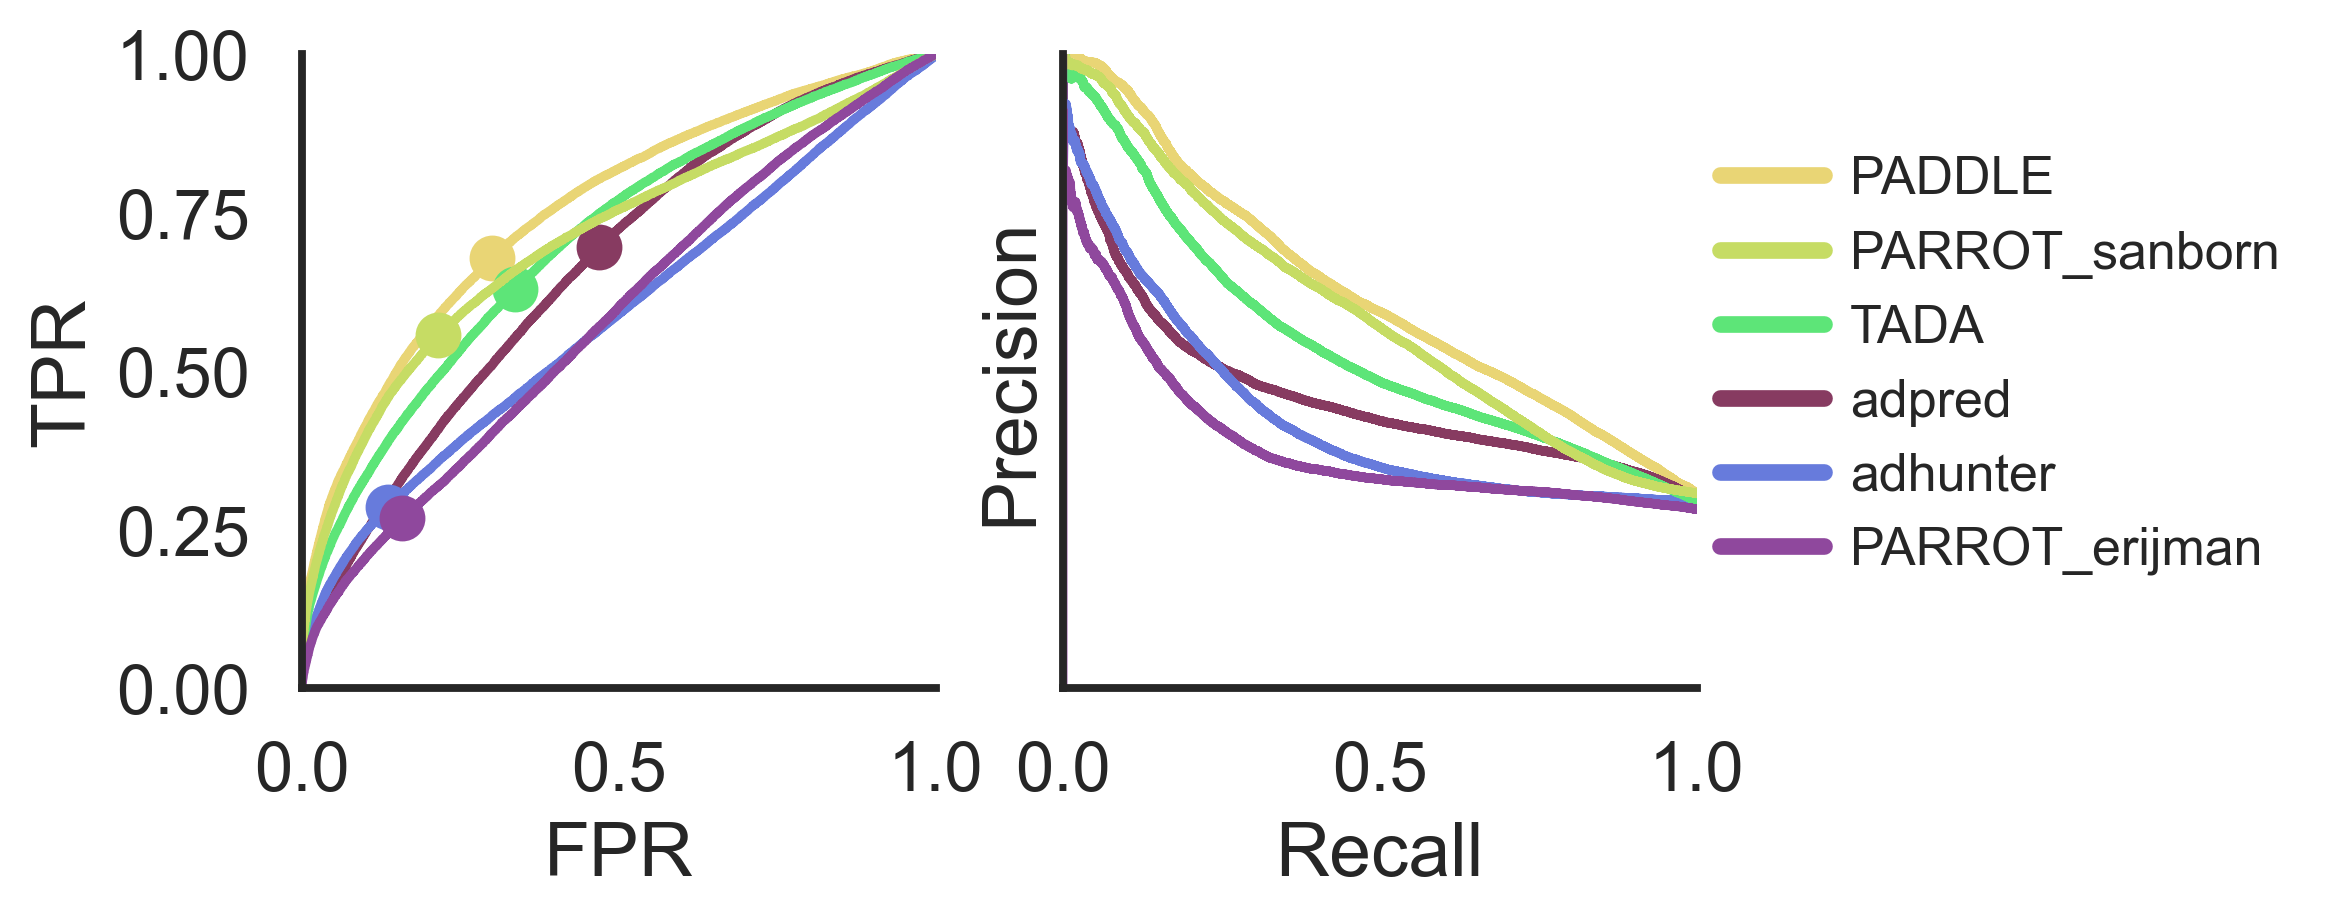

In [72]:
sns.set_context('talk')
fig, axs = plt.subplots(1,2, sharey = True, sharex = True)
results = []
# Plot ROC curves, save AUROC and Empirical threshold
auroc_paddle, Empirical_threshold_paddle = plot_AUPRC.plot_roc(paddle_with_truth, "preds", active_col_name="acidic_known_AD", ax=axs[0], color=color_palette_dict["PADDLE"], text=False, return_threshold=True)
results.append({"Predictor": "PADDLE", "AUROC": auroc_paddle, "Empirical Threshold": Empirical_threshold_paddle})

auroc_adpred, Empirical_threshold_adpred = plot_AUPRC.plot_roc(adpred_with_truth, "adpred", active_col_name="acidic_known_AD", color=color_palette_dict["adpred"], ax=axs[0], text=False, return_threshold=True)
results.append({"Predictor": "adpred", "AUROC": auroc_adpred, "Empirical Threshold": Empirical_threshold_adpred})

auroc_adhunter, Empirical_threshold_adhunter = plot_AUPRC.plot_roc(adhunter_with_truth, "adhunter", active_col_name="acidic_known_AD", color=color_palette_dict["adhunter"], ax=axs[0], text=False, return_threshold=True)
results.append({"Predictor": "adhunter", "AUROC": auroc_adhunter, "Empirical Threshold": Empirical_threshold_adhunter})

auroc_tada, Empirical_threshold_tada = plot_AUPRC.plot_roc(tada_with_truth, "tada", active_col_name="acidic_known_AD", color=color_palette_dict["TADA"], ax=axs[0], text=False, return_threshold=True)
results.append({"Predictor": "TADA", "AUROC": auroc_tada, "Empirical Threshold": Empirical_threshold_tada})

auroc_parrot_paddle, Empirical_threshold_parrot_paddle = plot_AUPRC.plot_roc(parrot_paddle_with_truth, "padd_pred", active_col_name="acidic_known_AD", color=color_palette_dict["PARROT_sanborn"], ax=axs[0], text=False, return_threshold=True)
results.append({"Predictor": "PARROT_sanborn", "AUROC": auroc_parrot_paddle, "Empirical Threshold": Empirical_threshold_parrot_paddle})

auroc_parrot_erij, Empirical_threshold_parrot_erij = plot_AUPRC.plot_roc(parrot_erij_with_truth, "erij_pred", active_col_name="acidic_known_AD", color=color_palette_dict["PARROT_erijman"], ax=axs[0], text=False, return_threshold=True)
results.append({"Predictor": "PARROT_erijman", "AUROC": auroc_parrot_erij, "Empirical Threshold": Empirical_threshold_parrot_erij})

# Plot PRC curves and save AUPRC
auprc_paddle = plot_AUPRC.plot_prc(paddle_with_truth, "preds", active_col_name="acidic_known_AD", ax=axs[1], subtract_prevalence=False, color=color_palette_dict["PADDLE"])
results[-6]["AUPRC"] = auprc_paddle

auprc_adpred = plot_AUPRC.plot_prc(adpred_with_truth, "adpred", active_col_name="acidic_known_AD", ax=axs[1], subtract_prevalence=False, color=color_palette_dict["adpred"])
results[-5]["AUPRC"] = auprc_adpred

auprc_adhunter = plot_AUPRC.plot_prc(adhunter_with_truth, "adhunter", active_col_name="acidic_known_AD", ax=axs[1], subtract_prevalence=False, color=color_palette_dict["adhunter"])
results[-4]["AUPRC"] = auprc_adhunter

auprc_tada = plot_AUPRC.plot_prc(tada_with_truth, "tada", active_col_name="acidic_known_AD", ax=axs[1], subtract_prevalence=False, color=color_palette_dict["TADA"])
results[-3]["AUPRC"] = auprc_tada

auprc_parrot_paddle = plot_AUPRC.plot_prc(parrot_paddle_with_truth, "padd_pred", active_col_name="acidic_known_AD", ax=axs[1], subtract_prevalence=False, color=color_palette_dict["PARROT_sanborn"])
results[-2]["AUPRC"] = auprc_parrot_paddle

auprc_parrot_erij = plot_AUPRC.plot_prc(parrot_erij_with_truth, "erij_pred", active_col_name="acidic_known_AD", ax=axs[1], subtract_prevalence=False, color=color_palette_dict["PARROT_erijman"])
results[-1]["AUPRC"] = auprc_parrot_erij

# Organize results into a DataFrame
results_df = pd.DataFrame(results)
results_df

legend_elements = [
    Line2D([0], [0], color=color_palette_dict["PADDLE"], lw=4, label="PADDLE"),
    Line2D([0], [0], color=color_palette_dict["PARROT_sanborn"], lw=4, label="PARROT_sanborn"),
    Line2D([0], [0], color=color_palette_dict["TADA"], lw=4, label="TADA"),
    Line2D([0], [0], color=color_palette_dict["adpred"], lw=4, label="adpred"),
    Line2D([0], [0], color=color_palette_dict["adhunter"], lw=4, label="adhunter"),
    Line2D([0], [0], color=color_palette_dict["PARROT_erijman"], lw=4, label="PARROT_erijman")
]

fig.legend(handles=legend_elements, loc="center right", bbox_to_anchor=(1.25, 0.5), fontsize='x-small', frameon=False, handletextpad=0.5)

In [73]:
results_df = results_df.sort_values(by = "AUROC", ascending = False)
results_df = results_df.round(3)
results_df = results_df.reset_index(drop = True)
results_df

,Predictor,AUROC,Empirical Threshold,AUPRC
0,PADDLE,0.753,0.262,0.622
1,PARROT_sanborn,0.709,0.370,0.590
2,TADA,0.704,0.194,0.541
3,adpred,0.662,0.003,0.463
4,adhunter,0.584,58224.740,0.427
5,PARROT_erijman,0.584,0.048,0.386


In [77]:
results_df["Threshold"] = [4, 4, 0.4, 0.8, 100000, 0.8]
results_df = results_df[["Predictor", "AUROC", "AUPRC", "Threshold", "Empirical Threshold"]]
results_df

,Predictor,AUROC,AUPRC,Threshold,Empirical Threshold
0,PADDLE,0.753,0.622,4.0,0.262
1,PARROT_sanborn,0.709,0.590,4.0,0.370
2,TADA,0.704,0.541,0.4,0.194
3,adpred,0.662,0.463,0.8,0.003
4,adhunter,0.584,0.427,100000.0,58224.740
5,PARROT_erijman,0.584,0.386,0.8,0.048


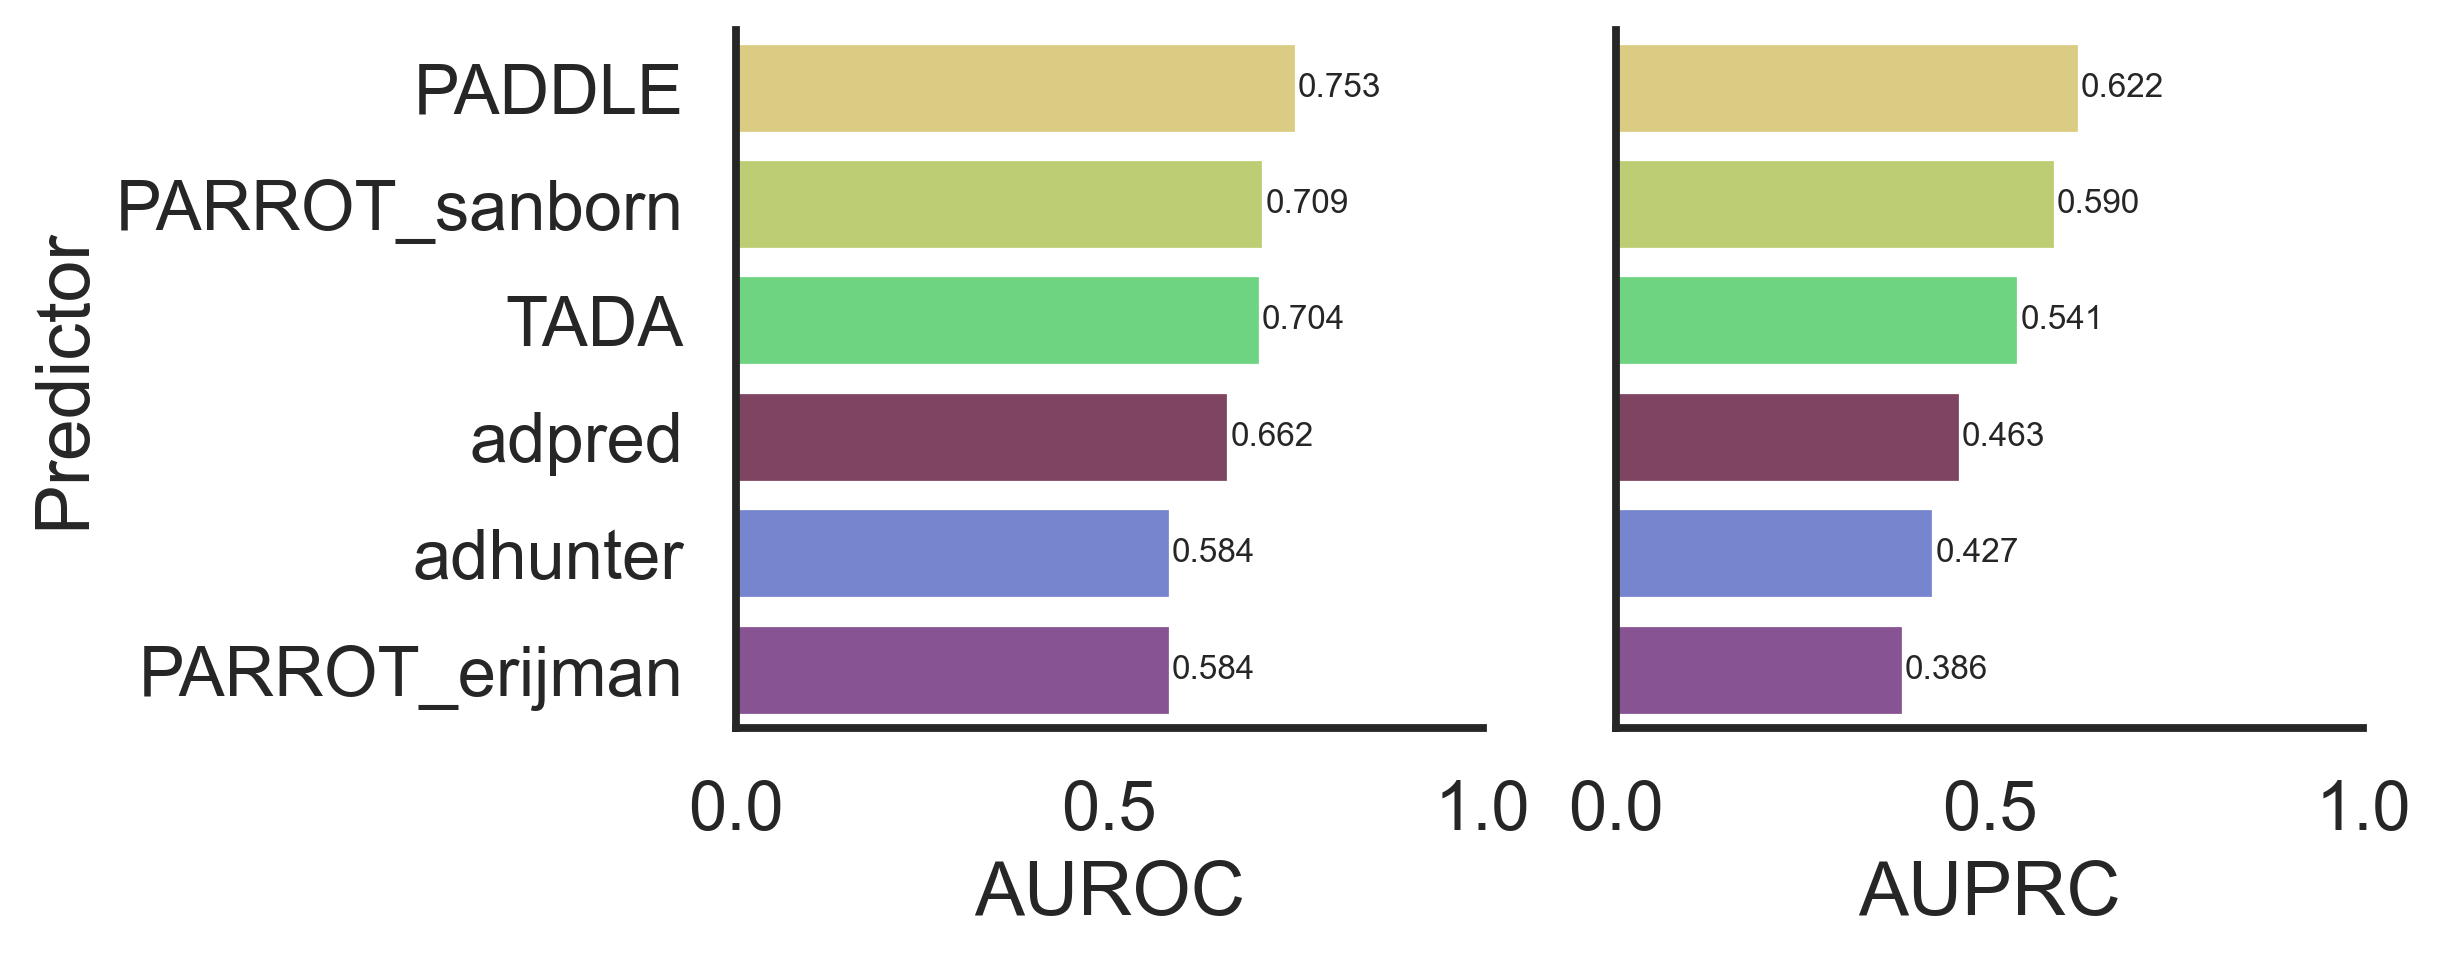

In [74]:
sns.set_style('white')
fig, axs = plt.subplots(1,2, sharey = True, figsize = (8,3))
sns.barplot(data=results_df, y="Predictor", x="AUROC", palette=color_palette_dict, ax=axs[0])
axs[0].set_xlim(0,1)

for i, row in results_df.iterrows():
    axs[0].text(row["AUROC"], i, f'{row["AUROC"]:.3f}', va='center', fontsize=8)

sns.barplot(data=results_df, y="Predictor", x="AUPRC", palette=color_palette_dict, ax=axs[1])
for i, row in results_df.iterrows():
    axs[1].text(row["AUPRC"], i, f'{row["AUPRC"]:.3f}', va='center', fontsize=8)
axs[1].set_xlim(0,1)

sns.despine()
plt.tight_layout(pad = 0)

# 5. F1 table: Use published threshold to binarize scores.

In [95]:
paddle_with_truth["binarized_pred"] = paddle_with_truth["preds"] > 4
paddle_with_truth

,tile,preds,GeneName,Start,End,uniprotID,acidic_known_AD,binarized_pred
0,MAEDDPYLGRPEQMFHLDPSLTHTIFNPEVFQPQMALPTDGPYLQI...,1.674334,sp|P19838|NFKB1_HUMAN,0,53,P19838,False,False
1,AEDDPYLGRPEQMFHLDPSLTHTIFNPEVFQPQMALPTDGPYLQIL...,1.473201,sp|P19838|NFKB1_HUMAN,1,54,P19838,False,False
2,EDDPYLGRPEQMFHLDPSLTHTIFNPEVFQPQMALPTDGPYLQILE...,1.325688,sp|P19838|NFKB1_HUMAN,2,55,P19838,False,False
3,DDPYLGRPEQMFHLDPSLTHTIFNPEVFQPQMALPTDGPYLQILEQ...,1.210825,sp|P19838|NFKB1_HUMAN,3,56,P19838,False,False
4,DPYLGRPEQMFHLDPSLTHTIFNPEVFQPQMALPTDGPYLQILEQP...,1.109244,sp|P19838|NFKB1_HUMAN,4,57,P19838,False,False
...,...,...,...,...,...,...,...,...
174434,SEMGPASKPSEDTGLATPARYREHRSNSQQGKSPDLHLLVDVACKQ...,0.014366,sp|Q4G112|HSF5_HUMAN,539,592,Q4G112,False,False
174435,EMGPASKPSEDTGLATPARYREHRSNSQQGKSPDLHLLVDVACKQE...,0.008490,sp|Q4G112|HSF5_HUMAN,540,593,Q4G112,False,False
174436,MGPASKPSEDTGLATPARYREHRSNSQQGKSPDLHLLVDVACKQER...,-0.015364,sp|Q4G112|HSF5_HUMAN,541,594,Q4G112,False,False
174437,GPASKPSEDTGLATPARYREHRSNSQQGKSPDLHLLVDVACKQERF...,-0.022012,sp|Q4G112|HSF5_HUMAN,542,595,Q4G112,False,False


In [96]:
parrot_paddle_with_truth["binarized_pred"] = parrot_paddle_with_truth["padd_pred"] > 4
parrot_paddle_with_truth

,tile,GeneName,Start,End,padd_pred,uniprotID,acidic_known_AD,binarized_pred
0,MRNRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLSKLECSG...,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,0,53,0.294699,A6NJG6,False,False
1,RNRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLSKLECSGT...,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,1,54,0.215838,A6NJG6,False,False
2,NRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLSKLECSGTV...,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,2,55,0.450520,A6NJG6,False,False
3,RMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLSKLECSGTVS...,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,3,56,0.251041,A6NJG6,False,False
4,MAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLSKLECSGTVSA...,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,4,57,0.478560,A6NJG6,False,False
...,...,...,...,...,...,...,...,...
185463,RRTAVIVQQKLRSSLLTKKQDQAARKIMRFLRRCRHSPLVDHRLYK...,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1616,1669,-0.021582,Q9Y6Y1,False,False
185464,RTAVIVQQKLRSSLLTKKQDQAARKIMRFLRRCRHSPLVDHRLYKR...,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1617,1670,-0.057513,Q9Y6Y1,False,False
185465,TAVIVQQKLRSSLLTKKQDQAARKIMRFLRRCRHSPLVDHRLYKRS...,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1618,1671,-0.083714,Q9Y6Y1,False,False
185466,AVIVQQKLRSSLLTKKQDQAARKIMRFLRRCRHSPLVDHRLYKRSE...,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1619,1672,-0.056512,Q9Y6Y1,False,False


In [97]:
tada_with_truth["binarized_pred"] = tada_with_truth["tada"] > 0.4
tada_with_truth

,uniprotID,tile,Start,End,tada,acidic_known_AD,binarized_pred
0,P57073,MLDMSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSE,0,40,0.188203,False,False
1,P57073,LDMSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSEG,1,41,0.175274,False,False
2,P57073,DMSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSEGL,2,42,0.171019,False,False
3,P57073,MSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSEGLG,3,43,0.173125,False,False
4,P57073,SEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSEGLGR,4,44,0.161011,False,False
...,...,...,...,...,...,...,...
189850,P48742,GPLHSMSAEVFGPSPPFSSLSVNGGASYGNHLSHPPEMNE,362,402,0.216110,False,False
189851,P48742,PLHSMSAEVFGPSPPFSSLSVNGGASYGNHLSHPPEMNEA,363,403,0.214454,False,False
189852,P48742,LHSMSAEVFGPSPPFSSLSVNGGASYGNHLSHPPEMNEAA,364,404,0.200905,False,False
189853,P48742,HSMSAEVFGPSPPFSSLSVNGGASYGNHLSHPPEMNEAAV,365,405,0.194064,False,False


In [98]:
adpred_with_truth["binarized_pred"] = adpred_with_truth["adpred"] > 0.8
adpred_with_truth

,tile,adpred,GeneName,Start,End,uniprotID,acidic_known_AD,binarized_pred
0,MLDMSEARSQPPCSPSGTASSMSHVEDSDS,0.000990,sp|P57073|SOX8_HUMAN,0,30,P57073,False,False
1,LDMSEARSQPPCSPSGTASSMSHVEDSDSD,0.000966,sp|P57073|SOX8_HUMAN,1,31,P57073,False,False
2,DMSEARSQPPCSPSGTASSMSHVEDSDSDA,0.000446,sp|P57073|SOX8_HUMAN,2,32,P57073,False,False
3,MSEARSQPPCSPSGTASSMSHVEDSDSDAP,0.000357,sp|P57073|SOX8_HUMAN,3,33,P57073,False,False
4,SEARSQPPCSPSGTASSMSHVEDSDSDAPP,0.000340,sp|P57073|SOX8_HUMAN,4,34,P57073,False,False
...,...,...,...,...,...,...,...,...
171325,LNQSHLSQHLNKGTPMKTQKRAALYTWYVR,0.000611,sp|P35680|HNF1B_HUMAN,144,174,P35680,False,False
171326,NQSHLSQHLNKGTPMKTQKRAALYTWYVRK,0.000197,sp|P35680|HNF1B_HUMAN,145,175,P35680,False,False
171327,QSHLSQHLNKGTPMKTQKRAALYTWYVRKQ,0.000136,sp|P35680|HNF1B_HUMAN,146,176,P35680,False,False
171328,SHLSQHLNKGTPMKTQKRAALYTWYVRKQR,0.000055,sp|P35680|HNF1B_HUMAN,147,177,P35680,False,False


In [99]:
parrot_erij_with_truth["binarized_pred"] = parrot_erij_with_truth["erij_pred"] > 0.8
parrot_erij_with_truth

,tile,GeneName,Start,End,W,F,Y,M,L,Q,K,R,D,E,Charge,erij_pred,uniprotID,acidic_known_AD,binarized_pred
0,MRNRMAPENPQPDPFINRNYSNMKVIPPQD,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,0,30,0,1,1,3,0,2,1,3,2,1,1,0.011447,A6NJG6,False,False
1,RNRMAPENPQPDPFINRNYSNMKVIPPQDP,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,1,31,0,1,1,2,0,2,1,3,2,1,1,0.009333,A6NJG6,False,False
2,NRMAPENPQPDPFINRNYSNMKVIPPQDPA,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,2,32,0,1,1,2,0,2,1,2,2,1,0,0.011541,A6NJG6,False,False
3,RMAPENPQPDPFINRNYSNMKVIPPQDPAS,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,3,33,0,1,1,2,0,2,1,2,2,1,0,0.011801,A6NJG6,False,False
4,MAPENPQPDPFINRNYSNMKVIPPQDPASP,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,4,34,0,1,1,2,0,2,1,1,2,1,-1,0.019178,A6NJG6,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196262,ARKIMRFLRRCRHSPLVDHRLYKRSERIEK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1639,1669,0,1,1,1,3,0,3,8,1,2,8,0.018220,Q9Y6Y1,False,False
196263,RKIMRFLRRCRHSPLVDHRLYKRSERIEKG,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1640,1670,0,1,1,1,3,0,3,8,1,2,8,0.014282,Q9Y6Y1,False,False
196264,KIMRFLRRCRHSPLVDHRLYKRSERIEKGQ,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1641,1671,0,1,1,1,3,1,3,7,1,2,7,0.015638,Q9Y6Y1,False,False
196265,IMRFLRRCRHSPLVDHRLYKRSERIEKGQG,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1642,1672,0,1,1,1,3,1,2,7,1,2,6,0.023222,Q9Y6Y1,False,False


In [100]:
adhunter_with_truth["binarized_pred"] = adhunter_with_truth["adhunter"] > 100000
adhunter_with_truth

,tile,adhunter,GeneName,Start,End,uniprotID,acidic_known_AD,binarized_pred
0,MLDMSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSE,21398.926,sp|P57073|SOX8_HUMAN,0,40,P57073,False,False
1,LDMSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSEG,19002.781,sp|P57073|SOX8_HUMAN,1,41,P57073,False,False
2,DMSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSEGL,21724.012,sp|P57073|SOX8_HUMAN,2,42,P57073,False,False
3,MSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSEGLG,21165.188,sp|P57073|SOX8_HUMAN,3,43,P57073,False,False
4,SEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSEGLGR,22060.988,sp|P57073|SOX8_HUMAN,4,44,P57073,False,False
...,...,...,...,...,...,...,...,...
189850,GPLHSMSAEVFGPSPPFSSLSVNGGASYGNHLSHPPEMNE,44033.600,sp|P48742|LHX1_HUMAN,362,402,P48742,False,False
189851,PLHSMSAEVFGPSPPFSSLSVNGGASYGNHLSHPPEMNEA,50841.470,sp|P48742|LHX1_HUMAN,363,403,P48742,False,False
189852,LHSMSAEVFGPSPPFSSLSVNGGASYGNHLSHPPEMNEAA,51227.438,sp|P48742|LHX1_HUMAN,364,404,P48742,False,False
189853,HSMSAEVFGPSPPFSSLSVNGGASYGNHLSHPPEMNEAAV,55368.594,sp|P48742|LHX1_HUMAN,365,405,P48742,False,False


In [105]:
def eval_model(model, preds_with_truth):
    tp = len(preds_with_truth[preds_with_truth["acidic_known_AD"] & preds_with_truth["binarized_pred"]])
    fp = len(preds_with_truth[~preds_with_truth["acidic_known_AD"] & preds_with_truth["binarized_pred"]])

    return model, sum(preds_with_truth["binarized_pred"]), sum(preds_with_truth["acidic_known_AD"]), sum(~preds_with_truth["acidic_known_AD"]), tp, fp

In [106]:

model_dict = {
    "tada": tada_with_truth,
    "adhunter": adhunter_with_truth,
    "adpred": adpred_with_truth,
    #"mechanistic": mechanistic,
    "paddle": paddle_with_truth,
    "parrot_erij": parrot_erij_with_truth,
    "parrot_paddle": parrot_paddle_with_truth
} 

model_results_df_fixed = pd.DataFrame(columns=["Predictor", "Predictions", "Positive Benchmark", "Negative Benchmark", "True Positives", "False Positives"])
for model in model_dict.keys():
    model_results_df_fixed.loc[len(model_results_df_fixed)] = eval_model(model, model_dict[model])
model_results_df_fixed

,Predictor,Predictions,Positive Benchmark,Negative Benchmark,True Positives,False Positives
0,tada,17363,55006,132029,11921,5442
1,adhunter,7810,55006,132029,5405,2405
2,adpred,6883,49931,117327,4598,2285
3,paddle,8456,52716,119865,7543,913
4,parrot_erij,6473,54233,137962,4200,2273
5,parrot_paddle,10114,56391,127219,8534,1580


In [107]:
model_results_df_fixed["False Negatives"] = model_results_df_fixed["Positive Benchmark"] - model_results_df_fixed["True Positives"]
model_results_df_fixed["Precision"] = (model_results_df_fixed["True Positives"] / (model_results_df_fixed["True Positives"] + model_results_df_fixed["False Positives"])).round(2)
model_results_df_fixed["Recall"] = (model_results_df_fixed["True Positives"] / (model_results_df_fixed["True Positives"] + model_results_df_fixed["False Negatives"])).round(2)
model_results_df_fixed["F1 Score"] = (2 * (model_results_df_fixed["Precision"] * model_results_df_fixed["Recall"]) / (model_results_df_fixed["Precision"] + model_results_df_fixed["Recall"])).round(2)
model_results_df_fixed

,Predictor,Predictions,Positive Benchmark,Negative Benchmark,True Positives,False Positives,False Negatives,Precision,Recall,F1 Score
0,tada,17363,55006,132029,11921,5442,43085,0.69,0.22,0.33
1,adhunter,7810,55006,132029,5405,2405,49601,0.69,0.10,0.17
2,adpred,6883,49931,117327,4598,2285,45333,0.67,0.09,0.16
3,paddle,8456,52716,119865,7543,913,45173,0.89,0.14,0.24
4,parrot_erij,6473,54233,137962,4200,2273,50033,0.65,0.08,0.14
5,parrot_paddle,10114,56391,127219,8534,1580,47857,0.84,0.15,0.25


In [108]:
final_results = model_results_df_fixed.sort_values(by = "F1 Score", ascending = False)
final_results

,Predictor,Predictions,Positive Benchmark,Negative Benchmark,True Positives,False Positives,False Negatives,Precision,Recall,F1 Score
0,tada,17363,55006,132029,11921,5442,43085,0.69,0.22,0.33
5,parrot_paddle,10114,56391,127219,8534,1580,47857,0.84,0.15,0.25
3,paddle,8456,52716,119865,7543,913,45173,0.89,0.14,0.24
1,adhunter,7810,55006,132029,5405,2405,49601,0.69,0.10,0.17
2,adpred,6883,49931,117327,4598,2285,45333,0.67,0.09,0.16
4,parrot_erij,6473,54233,137962,4200,2273,50033,0.65,0.08,0.14
